In [1]:
import tensorflow as tf
import numpy as np
import time
import scipy.io as sio
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import *
from tensorflow.keras.initializers import Constant
from tensorflow.keras import backend
import matplotlib.pyplot as plt
print(tf.__version__)

2.9.1


In [2]:
### This version is for forward model testing, and non-trainable
class Doublet_Metalens_EDOF:
    
    def encoder_forward(inputs):
        #def __init__(self):
            #optimizer = Adam(learning_rate=5e-4)
        #self.Doublet_Metalens_EDOF = self.encoder_forward()
        R_AL = 156.41968e-6 # Radius of Aperture Meta-lens (unit: m)
        R_FL = 321.4889e-6 # Radius of Focusing Meta-lens (unit: m)
        S = 320e-9 # Distance between Two Opposite Sides of a Nanofin (unit: m). This value is for determing the resolution of the two metalens.
        delta_2D = np.zeros([1,1024,1024,1],dtype=np.float32) 
        delta_2D[0,511:513,511:513,0] = 1 # To calculate the PSF
        lambda_d = 532e-9 # Design Wavelength (unite: m)
        f = 342.3e-6 # Focal Length (unite: m)
        z1 = 5e-4 # Thickness of SiO2 glass (unite: m)
        z2 = 100e-3 # Distance between the Meta-lens and the sensor (unite: m)
            #def rmse(y_true, y_pred):
            #    return backend.sqrt(backend.mean(backend.square(y_pred[:,:,:,0] - backend.squeeze(y_true,axis=3))))
            #self.Doublet_Metalens_EDOF.compile(optimizer=optimizer, loss='mean_squared_error',metrics=rmse)
        def phi_AL(a, R_AL, S):
            x = np.linspace(-R_AL,R_AL,num = int(R_AL/S))            
            y = x
            X, Y = np.meshgrid(x, y)
            PHI_AL = a.numpy()[0][0][0]*(np.sqrt(X*X+Y*Y)/R_AL)**2 + a.numpy()[0][0][1]*(np.sqrt(X*X+Y*Y)/R_AL)**4 + \
            a.numpy()[0][0][2]*(np.sqrt(X*X+Y*Y)/R_AL)**6 + a.numpy()[0][0][3]*(np.sqrt(X*X+Y*Y)/R_AL)**8 + \
            a.numpy()[0][0][4]*(np.sqrt(X*X+Y*Y)/R_AL)**10
            
            print('Coefficients a: ',a)
            plt.figure(figsize=(3, 3)) 
            plt.plot(x*1e6, PHI_AL[int(R_AL/S/2),:]/2/3.141592653) 
            plt.title('Phase profile of the aperture meta-lens')
            plt.xlabel('Radial coordinate (unit: um)')
            plt.ylabel('Phase profile (2*pi)')
            plt.show()
            return PHI_AL
            
        def phi_FL(b, R_FL, S):
            x = np.linspace(-R_FL,R_FL,num = int(R_FL/S))
            y = x
            X, Y = np.meshgrid(x, y)
            PHI_FL = -2*3.141592653/lambda_d*(np.sqrt(X*X+Y*Y+f*f)-f) + b.numpy()[0][0][0]*(np.sqrt(X*X+Y*Y)/R_FL)**2 + \
            b.numpy()[0][0][1]*(np.sqrt(X*X+Y*Y)/R_FL)**4 + b.numpy()[0][0][2]*(np.sqrt(X*X+Y*Y)/R_FL)**6 + \
            b.numpy()[0][0][3]*(np.sqrt(X*X+Y*Y)/R_FL)**8 + b.numpy()[0][0][4]*(np.sqrt(X*X+Y*Y)/R_FL)**10
            
            print('Coefficients b: ',b)
            plt.figure(figsize=(3, 3)) 
            plt.plot(x*1e6, PHI_FL[int(R_FL/S/2),:]/2/3.141592653) 
            plt.title('Phase profile of the focusing meta-lens')
            plt.xlabel('Radial coordinate (unit: um)')
            plt.ylabel('Phase profile (2*pi)')
            plt.show()
            return PHI_FL
            
        #inputs = Input(shape=(1,1))
        ### Aperture Meta-lens
        a = Dense(5,use_bias=False,kernel_initializer =Constant([-13.5078, 22.5578, -5.3161, 6.8526, -2.1028]))(inputs) # See Table S1
        PHI_AL = phi_AL(a, R_AL, S)
        print('Size in pixels of aperture meta-lens phase profile: ',PHI_AL.shape)
        Phase_AL = Lambda(backend.exp)(tf.dtypes.complex(np.zeros_like(PHI_AL), PHI_AL))
        x = np.linspace(-R_AL,R_AL,num = int(R_AL/S))            
        y = x
        X, Y = np.meshgrid(x, y)
        PSF_AL = Lambda(tf.signal.fft2d)(Phase_AL*Lambda(backend.exp)(tf.dtypes.complex(np.zeros_like(PHI_AL), 3.141592653/lambda_d/z1*(X*X+Y*Y))))
        PSF_AL = Lambda(backend.abs)(PSF_AL)
        PSF_AL = PSF_AL*PSF_AL
        
        fft_length = PSF_AL.shape[0]
        PSF_final = np.zeros([fft_length,fft_length]) # Fourer Transform
        PSF_final[0:int(fft_length/2),int(fft_length/2):fft_length] = PSF_AL[int(fft_length/2):fft_length,0:int(fft_length/2)]
        PSF_final[int(fft_length/2):fft_length,int(fft_length/2):fft_length] = PSF_AL[0:int(fft_length/2),0:int(fft_length/2)]
        PSF_final[0:int(fft_length/2),0:int(fft_length/2)] = PSF_AL[int(fft_length/2):fft_length,int(fft_length/2):fft_length]
        PSF_final[int(fft_length/2):fft_length,0:int(fft_length/2)] = PSF_AL[0:int(fft_length/2),int(fft_length/2):fft_length]
        PSF_AL_final = PSF_final
        PSF_AL_final = np.float32(np.expand_dims(np.expand_dims(PSF_AL_final,2),3))
        u1 = backend.conv2d(delta_2D, PSF_AL_final,strides=1,padding='same',data_format='channels_last',dilation_rate=1)
        ### Focusing Meta-lens
        b = Dense(5,use_bias=False,kernel_initializer = Constant([-50.0228, -391.0979, 153.7385, -45.8029, 5.7907]))(inputs) # See Table S2
        PHI_FL = phi_FL(b, R_FL, S)
        print('Size in pixels of focusing meta-lens phase profile: ',PHI_FL.shape)
        Phase_FL = Lambda(backend.exp)(tf.dtypes.complex(np.zeros_like(PHI_FL), PHI_FL))
        x = np.linspace(-R_FL,R_FL,num = int(R_FL/S))            
        y = x
        X, Y = np.meshgrid(x, y)
        PSF_FL = Lambda(tf.signal.fft2d)(Phase_FL*Lambda(backend.exp)(tf.dtypes.complex(np.zeros_like(PHI_FL), 3.141592653/lambda_d/z2*(X*X+Y*Y))))
        PSF_FL = Lambda(backend.abs)(PSF_FL)
        PSF_FL = PSF_FL*PSF_FL
        fft_length = PSF_AL.shape[0]
        PSF_final = np.zeros([fft_length,fft_length]) # Fourer Transform
        PSF_final[0:int(fft_length/2),int(fft_length/2):fft_length] = PSF_AL[int(fft_length/2):fft_length,0:int(fft_length/2)]
        PSF_final[int(fft_length/2):fft_length,int(fft_length/2):fft_length] = PSF_AL[0:int(fft_length/2),0:int(fft_length/2)]
        PSF_final[0:int(fft_length/2),0:int(fft_length/2)] = PSF_AL[int(fft_length/2):fft_length,int(fft_length/2):fft_length]
        PSF_final[int(fft_length/2):fft_length,0:int(fft_length/2)] = PSF_AL[0:int(fft_length/2),int(fft_length/2):fft_length]
        PSF_FL_final = PSF_final
        PSF_FL_final = np.float32(np.expand_dims(np.expand_dims(PSF_FL_final,2),3))
        u2 = backend.conv2d(u1, PSF_FL_final,strides=1,padding='same',data_format='channels_last',dilation_rate=1)
        outputs = Lambda(lambda x:(x-backend.min(x))/(backend.max(x)-backend.min(x)))(u2)
        return outputs

        
        

Coefficients a:  tf.Tensor([[[-13.5078  22.5578  -5.3161   6.8526  -2.1028]]], shape=(1, 1, 5), dtype=float32)


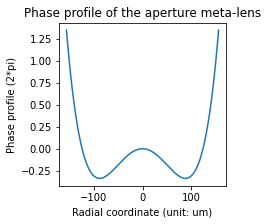

Size in pixels of aperture meta-lens phase profile:  (488, 488)
Coefficients b:  tf.Tensor([[[ -50.0228 -391.0979  153.7385  -45.8029    5.7907]]], shape=(1, 1, 5), dtype=float32)


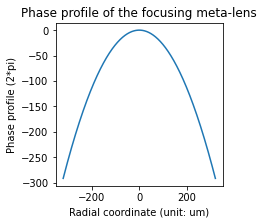

Size in pixels of focusing meta-lens phase profile:  (1004, 1004)


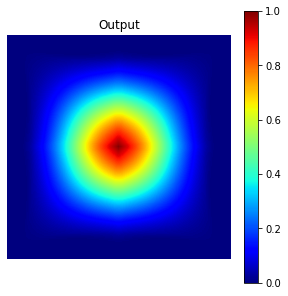

--- 27.374935150146484 seconds ---


In [3]:
start_time = time.time()
Input = np.ones((1,1,1),dtype=np.float32)
output = Doublet_Metalens_EDOF.encoder_forward(Input)

plt.figure(figsize=(5, 5)) 
plt.imshow(np.squeeze(output),cmap='jet')
plt.colorbar()
plt.title('Output')
plt.axis('off') 
plt.show()
print("--- %s seconds ---" % (time.time() - start_time))

In [4]:
### This version is for training
class Doublet_Metalens_EDOF:
    def __init__(self):
        self.channels = 1
        self.input_size = 1
        self.input_shape = (self.input_size, self.channels)
        self.R_AL = 156.41968e-6 # Radius of Aperture Meta-lens (unit: m)
        self.R_FL = 321.4889e-6 # Radius of Focusing Meta-lens (unit: m)
        self.S = 320e-9 # Distance between Two Opposite Sides of a Nanofin (unit: m). This value is for determing the resolution of the two metalens.
        self.delta_2D = np.zeros([1,1024,1024,1],dtype=np.float32) 
        self.delta_2D[0,511:513,511:513,0] = 1 # To calculate the PSF
        self.lambda_d = 532e-9 # Design Wavelength (unite: m)
        self.f = 342.3e-6 # Focal Length (unite: m)
        self.z1 = 1e-2 # Thickness of SiO2 glass (unite: m)
        self.z2 = 100e-3 # Distance between the Meta-lens and the sensor (unite: m)
        optimizer = Adam(learning_rate=1e-2)
        self.Doublet_Metalens_EDOF = self.encoder_forward()
        def rmse(y_true, y_pred):
            return backend.sqrt(backend.mean(backend.square(y_pred[:,:,:,0] - backend.squeeze(y_true,axis=3))))
        self.Doublet_Metalens_EDOF.compile(optimizer=optimizer, loss='mean_squared_error',metrics=rmse)
    
    def encoder_forward(self):
        inputs = tf.keras.Input(shape=self.input_shape)
        def phi_AL(a, R_AL, S):
            x = tf.linspace(-R_AL,R_AL,int(R_AL/S))
            y = x
            X, Y = tf.meshgrid(x, y)
            dense1 = Dense(1,use_bias=False,kernel_initializer =Constant([1,0,0,0,0]),trainable=False)
            a1 = Flatten()(dense1(a))
            dense2 = Dense(1,use_bias=False,kernel_initializer =Constant([0,1,0,0,0]),trainable=False)
            a2 = Flatten()(dense2(a))
            dense3 = Dense(1,use_bias=False,kernel_initializer =Constant([0,0,1,0,0]),trainable=False)
            a3 = Flatten()(dense3(a))
            dense4 = Dense(1,use_bias=False,kernel_initializer =Constant([0,0,0,1,0]),trainable=False)
            a4 = Flatten()(dense4(a))
            dense5 = Dense(1,use_bias=False,kernel_initializer =Constant([0,0,0,0,1]),trainable=False)
            a5 = Flatten()(dense5(a))

            PHI_AL = a1*(tf.math.sqrt(X*X+Y*Y)/R_AL)**2 + a2*(tf.math.sqrt(X*X+Y*Y)/R_AL)**4 + \
            a3*(tf.math.sqrt(X*X+Y*Y)/R_AL)**6 + a4*(tf.math.sqrt(X*X+Y*Y)/R_AL)**8 + \
            a5*(tf.math.sqrt(X*X+Y*Y)/R_AL)**10
            '''
            plt.figure(figsize=(3, 3)) 
            plt.plot(x*1e6, PHI_AL[int(R_AL/S/2),:]/2/np.pi) 
            plt.title('Phase profile of the aperture meta-lens')
            plt.xlabel('Radial coordinate (unit: um)')
            plt.ylabel('Phase profile (2*pi)')
            plt.show()
            '''
            return PHI_AL
            
        def phi_FL(b, R_FL, S):
            x = tf.linspace(-R_FL,R_FL,int(R_FL/S))
            y = x
            X, Y =tf.meshgrid(x, y)
            dense1 = Dense(1,use_bias=False,kernel_initializer =Constant([1,0,0,0,0]),trainable=False)
            b1 = Flatten()(dense1(b))
            dense2 = Dense(1,use_bias=False,kernel_initializer =Constant([0,1,0,0,0]),trainable=False)
            b2 = Flatten()(dense2(b))
            dense3 = Dense(1,use_bias=False,kernel_initializer =Constant([0,0,1,0,0]),trainable=False)
            b3 = Flatten()(dense3(b))
            dense4 = Dense(1,use_bias=False,kernel_initializer =Constant([0,0,0,1,0]),trainable=False)
            b4 = Flatten()(dense4(b))
            dense5 = Dense(1,use_bias=False,kernel_initializer =Constant([0,0,0,0,1]),trainable=False)
            b5 = Flatten()(dense5(b))
            PHI_FL = -2*3.141592653/self.lambda_d*(tf.math.sqrt(X*X+Y*Y+self.f*self.f)-self.f) + b1*(tf.math.sqrt(X*X+Y*Y)/R_FL)**2 + \
            b2*(tf.math.sqrt(X*X+Y*Y)/R_FL)**4 + b3*(tf.math.sqrt(X*X+Y*Y)/R_FL)**6 + \
            b4*(tf.math.sqrt(X*X+Y*Y)/R_FL)**8 + b5*(tf.math.sqrt(X*X+Y*Y)/R_FL)**10
            '''
            print('Coefficients b: ',b)
            plt.figure(figsize=(3, 3)) 
            plt.plot(x*1e6, PHI_FL[int(R_FL/S/2),:]) 
            plt.title('Phase profile of the focusing meta-lens')
            plt.xlabel('Radial coordinate (unit: um)')
            plt.ylabel('Phase profile (2*pi)')
            plt.show()
            '''
            return PHI_FL
            
        
        ### Aperture Meta-lens
        a = Dense(5,use_bias=False,kernel_initializer =Constant([-13.5078, 22.5578, -5.3161, 6.8526, -2.1028]))(inputs) # See Table S1
            
        PHI_AL = phi_AL(a, self.R_AL, self.S)
        Phase_AL = Lambda(backend.exp)(tf.dtypes.complex(tf.zeros_like(PHI_AL), PHI_AL))
        x = np.linspace(-self.R_AL,self.R_AL,num = int(self.R_AL/self.S))            
        y = x
        X, Y = np.meshgrid(x, y)
        PSF_AL = Lambda(tf.signal.fft2d)(Phase_AL*Lambda(backend.exp)(tf.dtypes.complex(tf.zeros_like(PHI_AL,dtype=tf.float32), tf.cast(np.pi/self.lambda_d/self.z1*(X*X+Y*Y),dtype=tf.float32))))
        PSF_AL = Lambda(tf.signal.fftshift)(PSF_AL)
        PSF_AL = Lambda(backend.abs)(PSF_AL)
        PSF_AL = PSF_AL*PSF_AL
        #fft_length = PSF_AL.shape[0]
        #PSF_final = tf.zeros([fft_length,fft_length]) # Fourer Transform
        #PSF_final[0:int(fft_length/2),int(fft_length/2):fft_length] = PSF_AL[int(fft_length/2):fft_length,0:int(fft_length/2)]
        #PSF_final[int(fft_length/2):fft_length,int(fft_length/2):fft_length] = PSF_AL[0:int(fft_length/2),0:int(fft_length/2)]
        #PSF_final[0:int(fft_length/2),0:int(fft_length/2)] = PSF_AL[int(fft_length/2):fft_length,int(fft_length/2):fft_length]
        #PSF_final[int(fft_length/2):fft_length,0:int(fft_length/2)] = PSF_AL[0:int(fft_length/2),int(fft_length/2):fft_length]
        PSF_AL_final = PSF_AL
        PSF_AL_final = tf.expand_dims(tf.expand_dims(PSF_AL_final,2),3)
        u1 = backend.conv2d(self.delta_2D, PSF_AL_final,strides=1,padding='same',data_format='channels_last',dilation_rate=1)
        ### Focusing Meta-lens
        b = Dense(5,use_bias=False,kernel_initializer = Constant([-50.0228, -391.0979, 153.7385, -45.8029, 5.7907]))(inputs) # See Table S2
        PHI_FL = phi_FL(b, self.R_FL, self.S)
        x = np.linspace(-self.R_FL,self.R_FL,num = int(self.R_FL/self.S))            
        y = x
        X, Y = np.meshgrid(x, y)
        Phase_FL = Lambda(backend.exp)(tf.dtypes.complex(tf.zeros_like(PHI_FL), PHI_FL))
        PSF_FL = Lambda(tf.signal.fft2d)(Phase_FL*Lambda(backend.exp)(tf.dtypes.complex(tf.zeros_like(PHI_FL,dtype=tf.float32),  tf.cast(np.pi/self.lambda_d/self.z2*(X*X+Y*Y),dtype=tf.float32))))
        PSF_FL = Lambda(tf.signal.fftshift)(PSF_FL)
        PSF_FL = Lambda(backend.abs)(PSF_FL)
        PSF_FL = PSF_FL*PSF_FL
        #fft_length = PSF_FL.shape[0]
        #PSF_final = np.zeros([fft_length,fft_length]) # Fourer Transform
        #PSF_final[0:int(fft_length/2),int(fft_length/2):fft_length] = PSF_AL[int(fft_length/2):fft_length,0:int(fft_length/2)]
        #PSF_final[int(fft_length/2):fft_length,int(fft_length/2):fft_length] = PSF_AL[0:int(fft_length/2),0:int(fft_length/2)]
        #PSF_final[0:int(fft_length/2),0:int(fft_length/2)] = PSF_AL[int(fft_length/2):fft_length,int(fft_length/2):fft_length]
        #PSF_final[int(fft_length/2):fft_length,0:int(fft_length/2)] = PSF_AL[0:int(fft_length/2),int(fft_length/2):fft_length]
        PSF_FL_final = PSF_FL
        PSF_FL_final = tf.expand_dims(tf.expand_dims(PSF_FL_final,2),3)
        u2 = backend.conv2d(u1, PSF_FL_final,strides=1,padding='same',data_format='channels_last',dilation_rate=1)
        outputs = Lambda(lambda x:(x-backend.min(x))/(backend.max(x)-backend.min(x)))(u2) 
        '''
        plt.figure(figsize=(5, 5)) 
        plt.imshow(np.squeeze(output),cmap='gray')
        plt.colorbar()
        plt.title('Output')
        plt.axis('off') 
        plt.show()
        '''
        print('*****Shape of the output layer*****',outputs.shape)
        return Model(inputs = inputs, outputs = outputs)
    
    def train(self, X, Y, epochs, batch_size=1):
        self.Doublet_Metalens_EDOF.summary()
        for i in range(epochs):
            
            start_time = time.time()
            
            loss, error = self.Doublet_Metalens_EDOF.train_on_batch(X, Y)
            print('Epoch: ',i+1,'/',epochs,', loss: ', loss,'Mean absoluate error: ',error)
            print('Coefficients a: ',self.Doublet_Metalens_EDOF.layers[1].get_weights()[0])
            print('Coefficients b: ',self.Doublet_Metalens_EDOF.layers[2].get_weights()[0])
            pred = self.Doublet_Metalens_EDOF.predict_on_batch(X)
            plt.figure(figsize=(10, 5))
            plt.subplot(1,2,1)
            plt.imshow(np.squeeze(pred),cmap='jet')
            plt.colorbar()
            plt.title('Output')
            plt.axis('off') 
            plt.subplot(1,2,2)
            plt.imshow(np.squeeze(Y),cmap='jet')
            plt.colorbar()
            plt.title('GT')
            plt.axis('off') 
            plt.show()
            print("--- %s seconds for epoch ---" % (time.time() - start_time))
        self.Doublet_Metalens_EDOF.save('Doublet_Metalens_EDOF.h5')
        
    #def test:
        
        

*****Shape of the output layer***** (1, 1024, 1024, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 1)]       0           []                               
                                                                                                  
 dense_2 (Dense)                (None, 1, 5)         5           ['input_1[0][0]']                
                                                                                                  
 dense_8 (Dense)                (None, 1, 5)         5           ['input_1[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 1, 1)         5           ['dense_2[0][0]']                
                                       

 )                                                                                                
                                                                                                  
 tf.__operators__.add_6 (TFOpLa  (1004, 1004)        0           ['tf.__operators__.add_5[0][0]', 
 mbda)                                                            'tf.math.multiply_9[0][0]']     
                                                                                                  
 tf.math.multiply_10 (TFOpLambd  (1004, 1004)        0           ['flatten_8[0][0]']              
 a)                                                                                               
                                                                                                  
 flatten_9 (Flatten)            (None, 1)            0           ['dense_13[0][0]']               
                                                                                                  
 tf.__oper

 tf.expand_dims_3 (TFOpLambda)  (1004, 1004, 1, 1)   0           ['tf.expand_dims_2[0][0]']       
                                                                                                  
 tf.compat.v1.nn.convolution_1   (1, 1024, 1024, 1)  0           ['tf.compat.v1.nn.convolution[0][
 (TFOpLambda)                                                    0]',                             
                                                                  'tf.expand_dims_3[0][0]']       
                                                                                                  
 lambda_19 (Lambda)             (1, 1024, 1024, 1)   0           ['tf.compat.v1.nn.convolution_1[0
                                                                 ][0]']                           
                                                                                                  
Total params: 60
Trainable params: 10
Non-trainable params: 50
______________________________________________

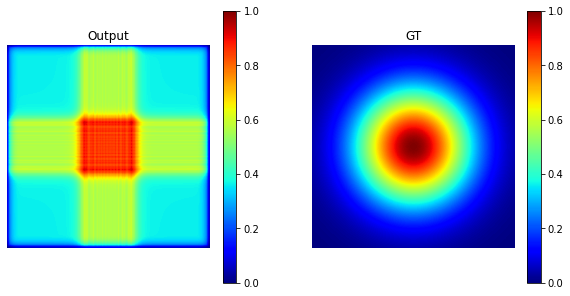

--- 153.859192609787 seconds for epoch ---
Epoch:  2 / 10 , loss:  0.07504424452781677 Mean absoluate error:  0.2739420533180237
Coefficients a:  [[-13.52778   22.537926  -5.297357   6.871973  -2.083566]]
Coefficients b:  [[ -50.03966   -391.09253    153.75069    -45.785835     5.8095145]]


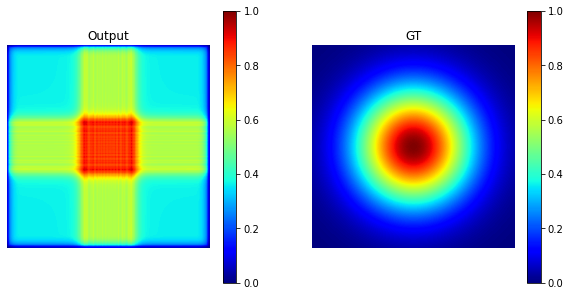

--- 9.359503746032715 seconds for epoch ---
Epoch:  3 / 10 , loss:  0.07495374232530594 Mean absoluate error:  0.2737767994403839
Coefficients a:  [[-13.537763   22.528074   -5.288134    6.881487   -2.0741725]]
Coefficients b:  [[ -50.048233  -391.09982    153.74644    -45.784496     5.8157277]]


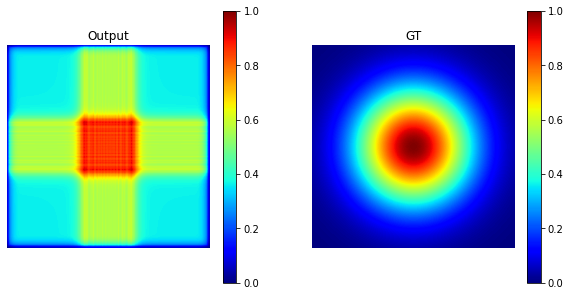

--- 9.34342908859253 seconds for epoch ---
Epoch:  4 / 10 , loss:  0.07485341280698776 Mean absoluate error:  0.2735935151576996
Coefficients a:  [[-13.547738   22.518312   -5.2787113   6.8911314  -2.0646088]]
Coefficients b:  [[ -50.057316  -391.10815    153.73987    -45.787075     5.8192067]]


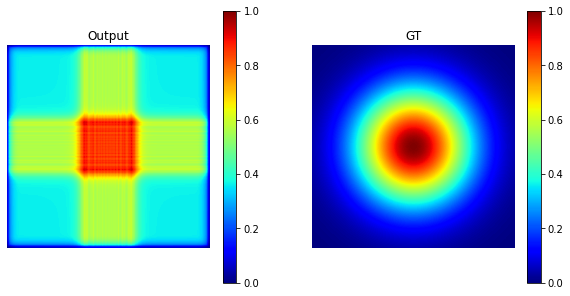

--- 9.406286478042603 seconds for epoch ---
Epoch:  5 / 10 , loss:  0.07470192760229111 Mean absoluate error:  0.27331653237342834
Coefficients a:  [[-13.557708   22.508646   -5.2690945   6.900921   -2.054873 ]]
Coefficients b:  [[ -50.066727 -391.11703   153.7322    -45.79163     5.820949]]


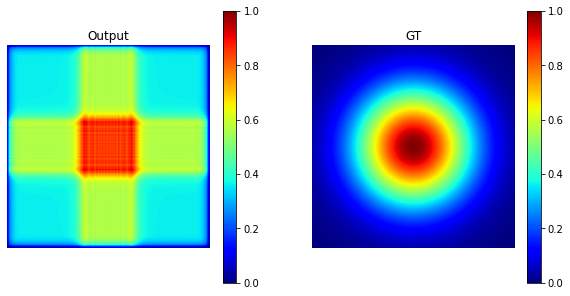

--- 9.343915700912476 seconds for epoch ---
Epoch:  6 / 10 , loss:  0.07453033328056335 Mean absoluate error:  0.2730024456977844
Coefficients a:  [[-13.567674   22.49906    -5.2593036   6.9108415  -2.0449922]]
Coefficients b:  [[ -50.076298 -391.1262    153.72401   -45.797035    5.822135]]


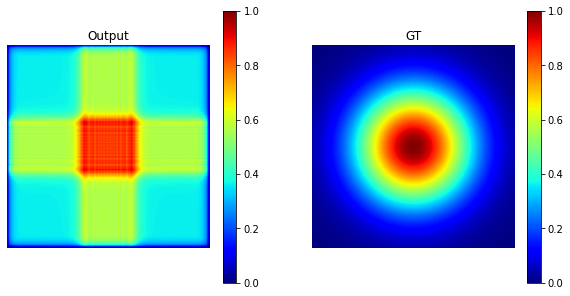

--- 9.4366455078125 seconds for epoch ---
Epoch:  7 / 10 , loss:  0.0743696540594101 Mean absoluate error:  0.272707998752594
Coefficients a:  [[-13.577638   22.489521   -5.2493834   6.920845   -2.0350335]]
Coefficients b:  [[ -50.085854  -391.13538    153.71577    -45.802467     5.8237996]]


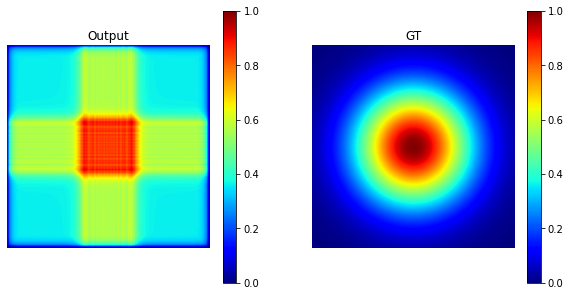

--- 9.422931909561157 seconds for epoch ---
Epoch:  8 / 10 , loss:  0.07423492521047592 Mean absoluate error:  0.2724608778953552
Coefficients a:  [[-13.587602   22.479982   -5.239421    6.9308367  -2.0251224]]
Coefficients b:  [[ -50.095238  -391.14438    153.70782    -45.807236     5.8266087]]


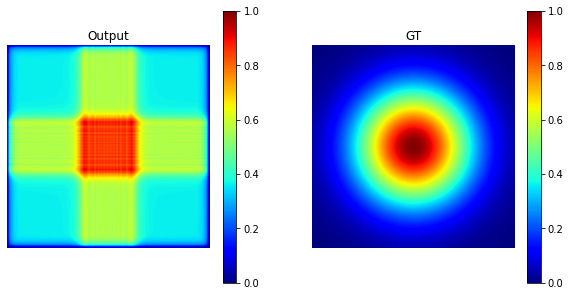

--- 9.406529664993286 seconds for epoch ---
Epoch:  9 / 10 , loss:  0.07412052154541016 Mean absoluate error:  0.27225083112716675
Coefficients a:  [[-13.597568   22.470392   -5.229558    6.940664   -2.0154612]]
Coefficients b:  [[ -50.10435   -391.15305    153.7004     -45.81091      5.8307176]]


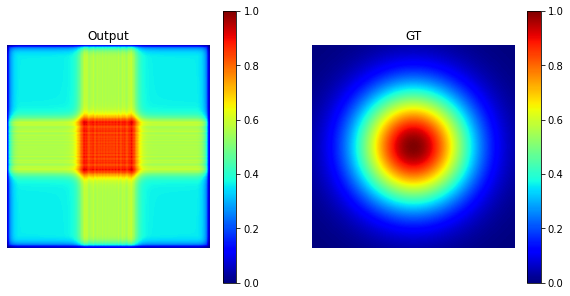

--- 9.562431812286377 seconds for epoch ---


In [ ]:
def gaus2d(x=0, y=0, mx=0, my=0, sx=2, sy=2):
    return 1. / (2. * 3.141592653 * sx * sy) * np.exp(-((x - mx)**2. / (2. * sx**2.) + (y - my)**2. / (2. * sy**2.)))
x = np.linspace(-5, 5, num = 1024)
y = np.linspace(-5, 5, num = 1024)
x, y = np.meshgrid(x, y) # get 2D variables instead of 1D
GT = gaus2d(x, y).astype(np.float32) # Here we use a Gaussian Mask as an example of ground truth
GT = (GT-np.amin(GT))/(np.amax(GT)-np.amin(GT))
GT = np.expand_dims(np.expand_dims(GT, axis = 2), axis = 0)

Input = np.ones((1,1,1),dtype=np.float32)
model = Doublet_Metalens_EDOF()
model.train(Input, GT, epochs=10, batch_size=1)
'''
pred = model.predict_on_batch(Input)

plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.imshow(np.squeeze(pred),cmap='gray')
plt.colorbar()
plt.title('Output')
plt.axis('off') 
plt.subplot(1,2,2)
plt.imshow(np.squeeze(GT),cmap='gray')
plt.colorbar()
plt.title('GT')
plt.axis('off') 
plt.show()
'''
